# blurrying effect characterization




In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from xhistogram.xarray import histogram
import dashydro.hydro as hy

import sstats.sigp as sigp

---

## load data

Data clean with `inspect.ipynb` notebook

In [2]:
root_data_dir = "/Users/aponte/Cloud/Dropbox/Public/das"
zarr = os.path.join(root_data_dir, "das/DAST_Toulon_July2019_strain_clean.zarr")

In [3]:
ds = xr.open_zarr(zarr)
ds

<xarray.Dataset>
Dimensions:  (channel: 2000, time: 12708)
Coordinates:
  * channel  (channel) int64 1 2 3 4 5 6 7 ... 1995 1996 1997 1998 1999 2000
    depth    (channel) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lat      (channel) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lon      (channel) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    s        (channel) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2019-07-13T16:37:52 ... 2019-07-31T08:17:56
Data variables:
    strain   (channel, time) float64 dask.array<chunksize=(1120, 6354), meta=np.ndarray>

---
## inspect visually time series

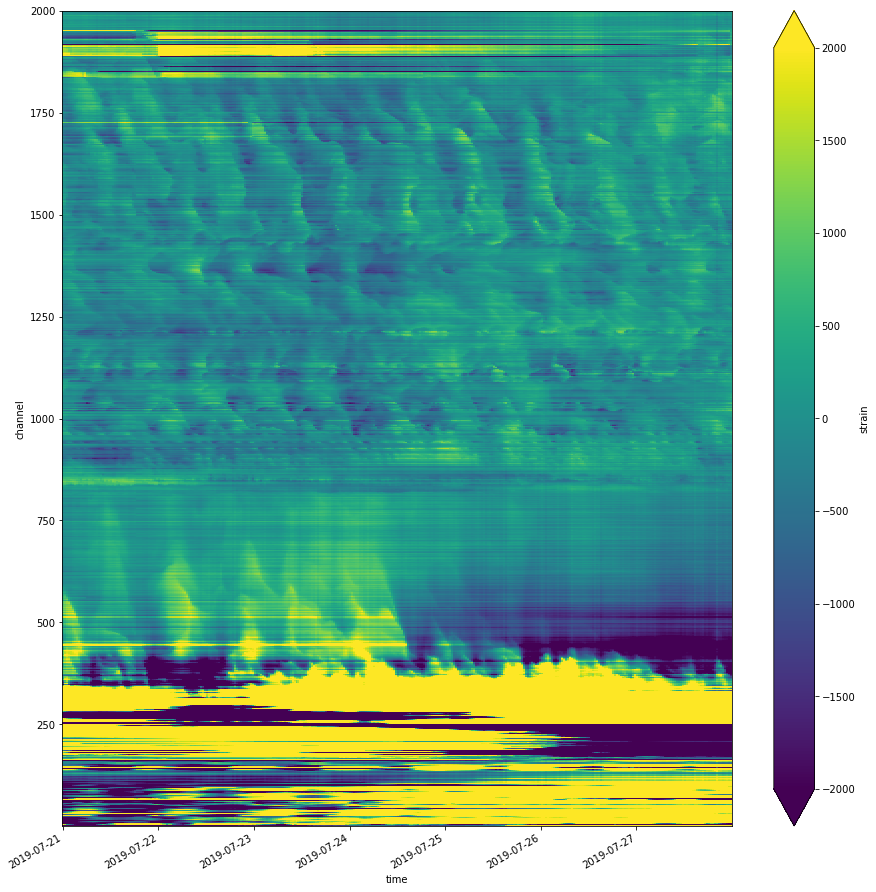

In [4]:
tslice = slice(0,None,15)

vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None
_da = ds.strain.isel(time=tslice)
_da = _da.sel(time=slice("2019/07/21","2019/07/27"))

_da.plot(vmin=vmin, vmax=vmax, figsize=(15,15))

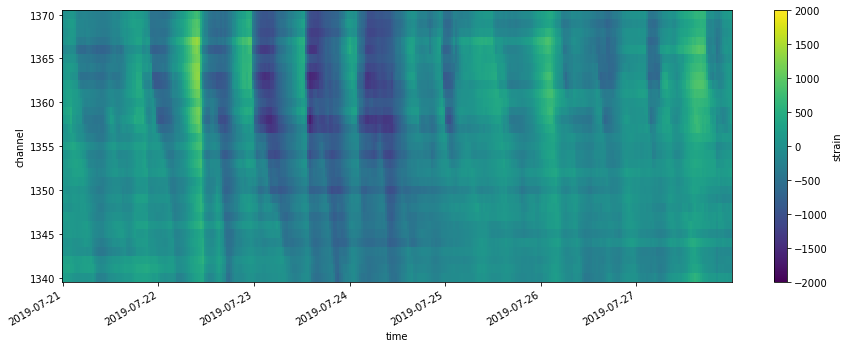

In [5]:
vmin, vmax= -2e3, 2e3
#vmin, vmax = None, None
_da = ds.strain.isel(time=tslice).sel(channel=slice(1340,1370))
_da = _da.sel(time=slice("2019/07/21","2019/07/27"))

_da.plot(vmin=vmin, vmax=vmax, figsize=(15,5))

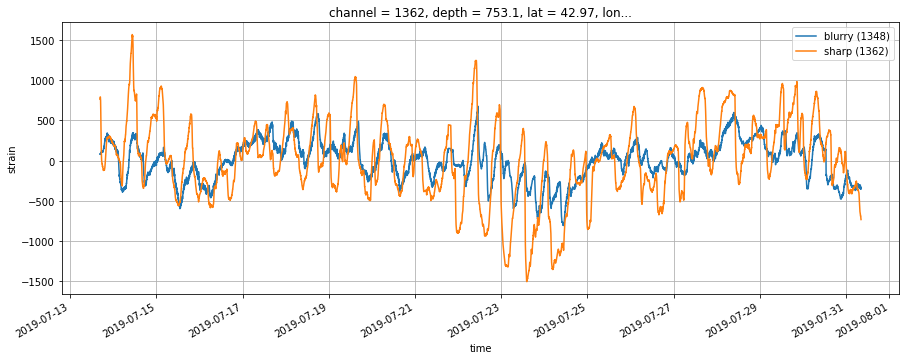

In [6]:
c0, c1 = 1348, 1362

s0 = ds.strain.sel(channel=c0)
s1 = ds.strain.sel(channel=c1)

fig, ax = plt.subplots(1,1, figsize=(15,5))

s0.plot(label=f"blurry ({int(s0.channel)})")
s1.plot(label=f"sharp ({int(s1.channel)})")

ax.legend()
ax.grid()

## spectra calculation: power spectrum and coherence

In [9]:
def _preprocess(da):
    da = da - da.mean()
    da = da.fillna(0)
    da = da.assign_coords(time=(da.time - da.time[0])/pd.Timedelta("1D"))    
    return da

def spectra(x, T, y=None):
    x = _preprocess(x)
    if y is not None:
        y = _preprocess(y)
    E, f = sigp.spectrum_welch(x, 
                               y=y,
                               T=T,
                               return_onesided=True,
                               detrend="linear",
                              )
    return E.persist()

In [10]:
_strain = ds.strain

# check add a synthetic inertial oscillation to validate the spectral calculation
if False: 
    f, f_cpd = hy.get_f(hy.toulon["lat"])
    t = (_strain.time - _strain.time[0])/pd.Timedelta("1D")
    _strain = _strain + 1e5*np.cos(2*np.pi*f_cpd*t)
    _strain.isel(time=tslice).plot()

E = spectra(_strain, T=5).rename("E")

# cross spsectrum
c_ref = 1362 # sharp channel
C = spectra(_strain, y=_strain.sel(channel=c_ref), T=5).rename("C")

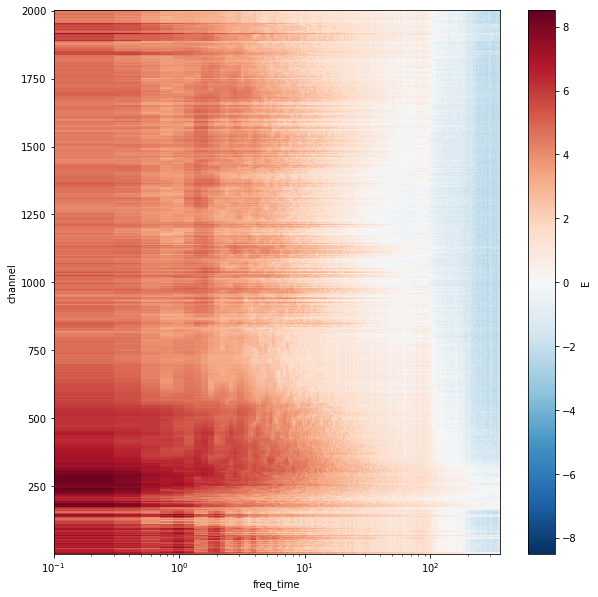

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_E = E.where(E.freq_time>0, drop=True)
np.log10(_E).plot(x="freq_time")
ax.set_xscale("log")

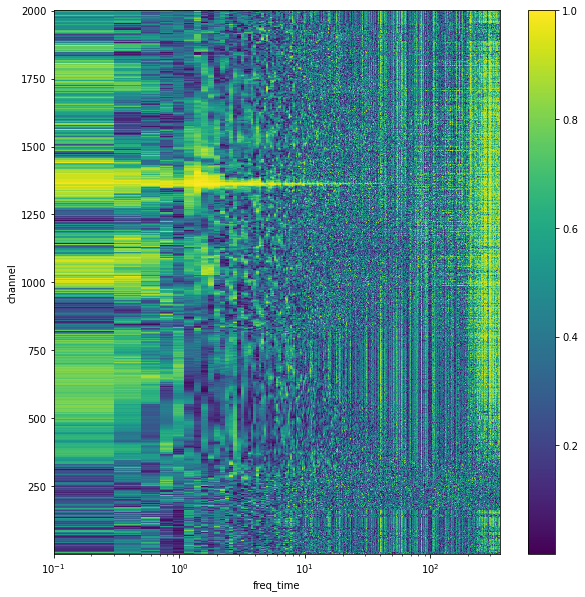

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_C = C.where(C.freq_time>0, drop=True)
_C = np.abs(_C)/np.sqrt(E*E.sel(channel=c_ref))
_C.plot(x="freq_time")
ax.set_xscale("log")

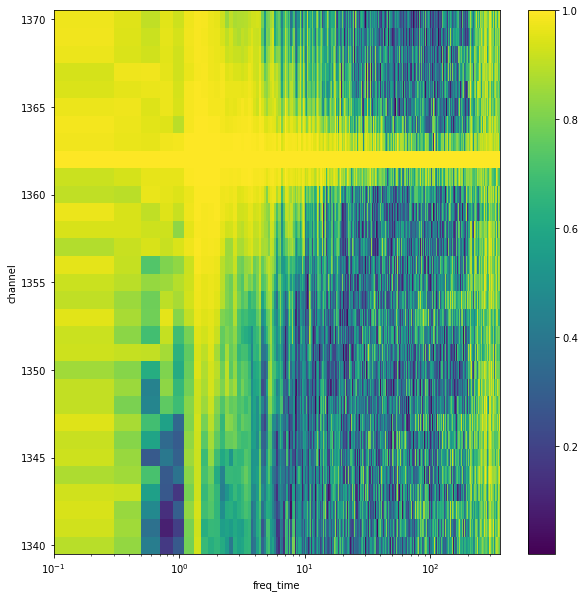

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_C = C.where(C.freq_time>0, drop=True)
_C = _C.sel(channel=slice(1340,1370))
_C = np.abs(_C)/np.sqrt(E*E.sel(channel=c_ref))
_C.plot(x="freq_time")
ax.set_xscale("log")

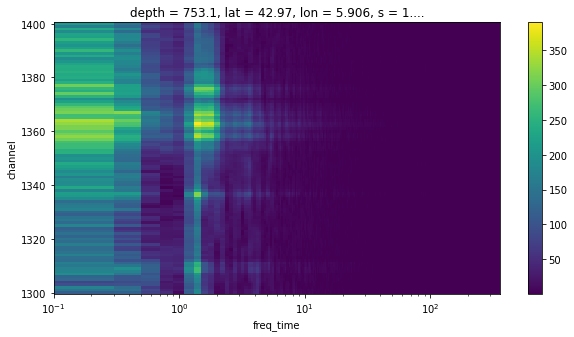

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
_C = C.where(C.freq_time>0, drop=True)
_C = _C.sel(channel=slice(1300,1400))
_C = np.abs(_C)/np.sqrt(E.sel(channel=c_ref))
_C.plot(x="freq_time")
ax.set_xscale("log")

Text(0.5, 0, 'frequency [cycles per days]')

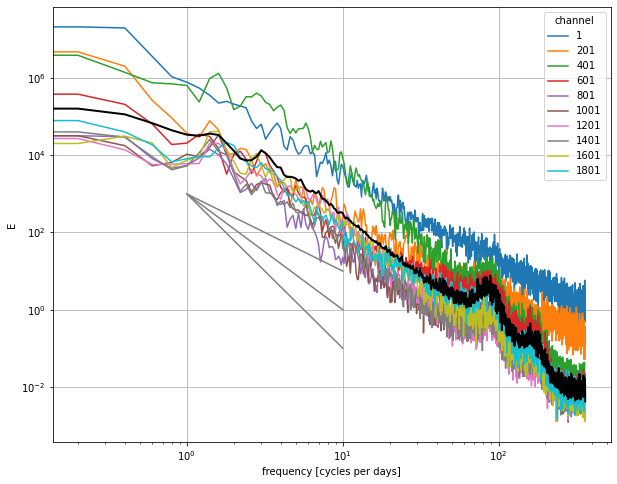

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

_E = E.sel(channel=slice(0,None,200))
_E.plot.line(x="freq_time");

E_mean = E.sel(channel=slice(500,1500)).mean("channel")
E_mean.plot.line(x="freq_time", color="k", lw=2);

_f = np.array([1, 1e1])
ax.plot(_f, 1e3*(_f/_f[0])**-2, color="0.5")
ax.plot(_f, 1e3*(_f/_f[0])**-3, color="0.5")
ax.plot(_f, 1e3*(_f/_f[0])**-4, color="0.5")

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()

ax.set_xlabel("frequency [cycles per days]")

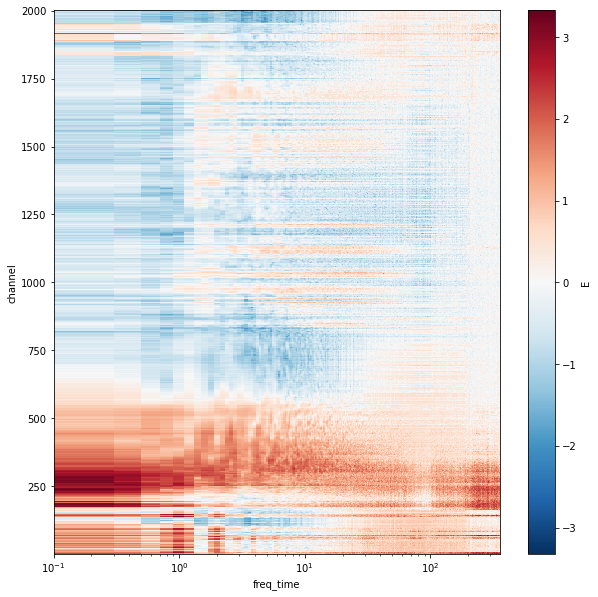

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_E = E.where(E.freq_time>0, drop=True)
np.log10(_E/E_mean).plot(x="freq_time")
ax.set_xscale("log")

---

## integrate in several frequency bands of interest

In [19]:
f, f_cpd = hy.get_f(hy.toulon["lat"])

bands = dict(inertial=(f_cpd-0.2, f_cpd+0.2),
             central=(10-2, 10+2),
             high0=(60,100),
            )

Eb = xr.concat([E.where( (E.freq_time>b[0]) & (E.freq_time<b[1]), other=0).integrate("freq_time") 
               for _, b in bands.items()], pd.Index(list(bands), name="band")
              ).compute()


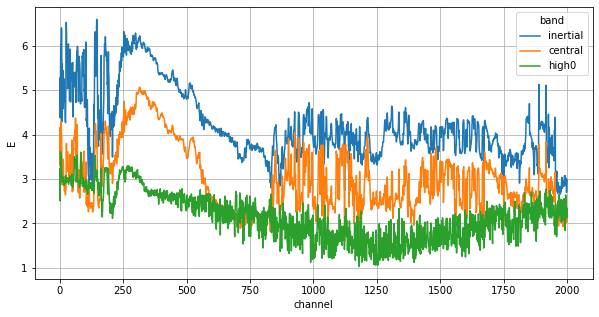

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
np.log10(Eb).plot(x="channel", hue="band")
ax.grid()

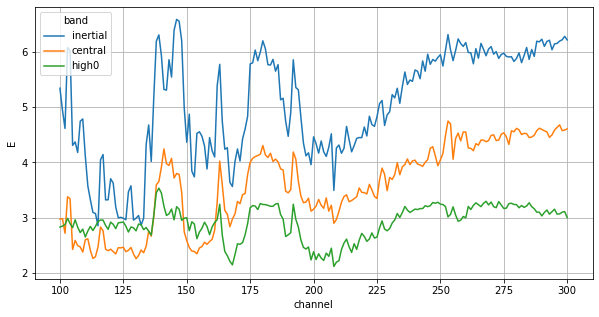

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
np.log10(Eb).sel(channel=slice(100, 300)).plot(x="channel", hue="band")
ax.grid()

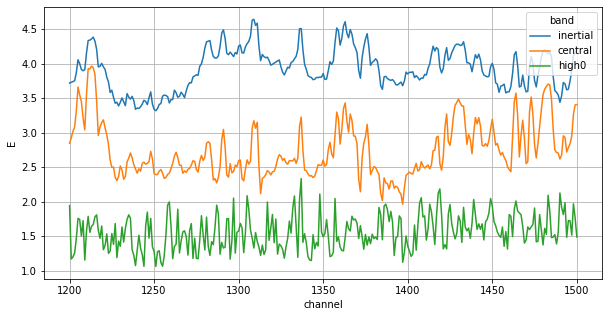

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
np.log10(Eb).sel(channel=slice(1200, 1500)).plot(x="channel", hue="band")
ax.grid()

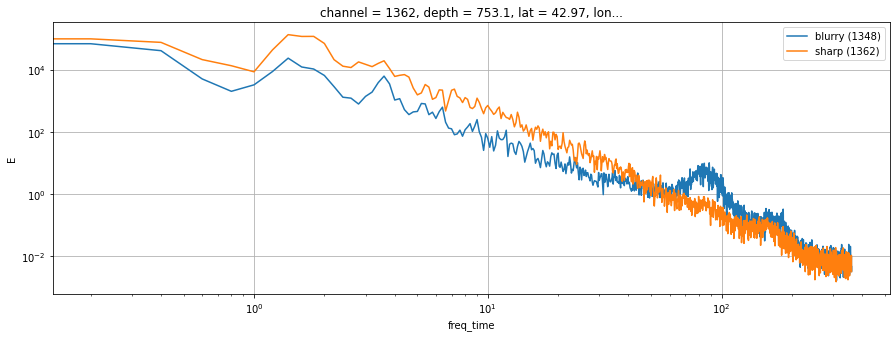

In [22]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

E.sel(channel=c0).plot(label=f"blurry ({int(s0.channel)})")
E.sel(channel=c1).plot(label=f"sharp ({int(s1.channel)})")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
ax.grid()

---

## focus on the high frequency peak ("noise"?)

In [43]:
df = float(E.freq_time[1] - E.freq_time[0])
E_high = E.where( (E.freq_time>60) & (E.freq_time<100), other=0.).sum("freq_time")*df
E_high = E_high.compute()

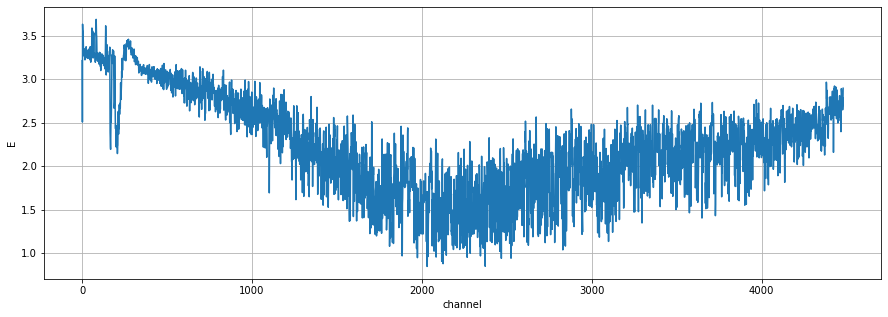

In [44]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
np.log10(E_high).plot()
ax.grid()

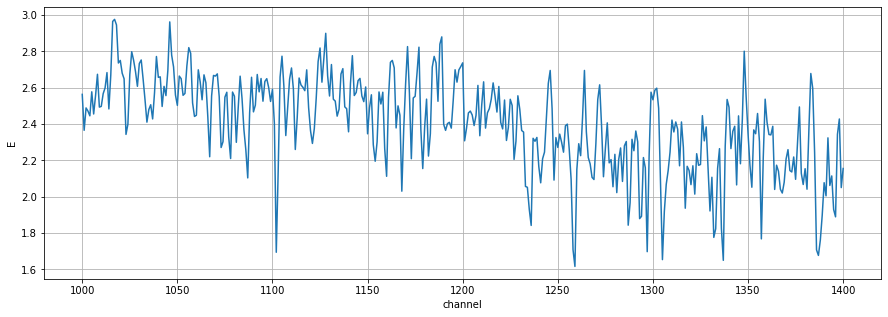

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
np.log10(E_high.sel(channel=slice(1000,1400))).plot()
ax.grid()

---
### to be updated: compute and show autocorrelations and spectra

Could use variograms instead of autocorrelations


These could be used to:

- detect variations of coupling conditions
- compare with canonical spectral distributions of internal wave variability

In [27]:

def autocorrelation(x):    
    da = x - x.mean()
    da = da.fillna(0)
    da = da.assign_coords(time=(da.time - da.time[0])/pd.Timedelta("1H"))
    c = sigp.correlate(da, da).compute()
    return c

In [ ]:
C = autocorrelation(ds.strain2).rename("C")

In [ ]:
lag_slice = slice(0,None, 10)

In [ ]:
C.isel(lags=lag_slice).plot(x="lags")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_C = (C.isel(lags=lag_slice)/C.sel(lags=0))
_C.plot(x="lags")

In [34]:
dstrain_dt = ds.strain.diff("time").rename("d(strain)/dt")
dstrain_dc = ds.strain.diff("channel").rename("d(strain)/dc")
h_t = histogram(dstrain_dt, dim=["time"], bins=np.arange(-100,100,1), density=True)
h_c = histogram(dstrain_dc, dim=["channel"], bins=np.arange(-1000,1000,10), density=True)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


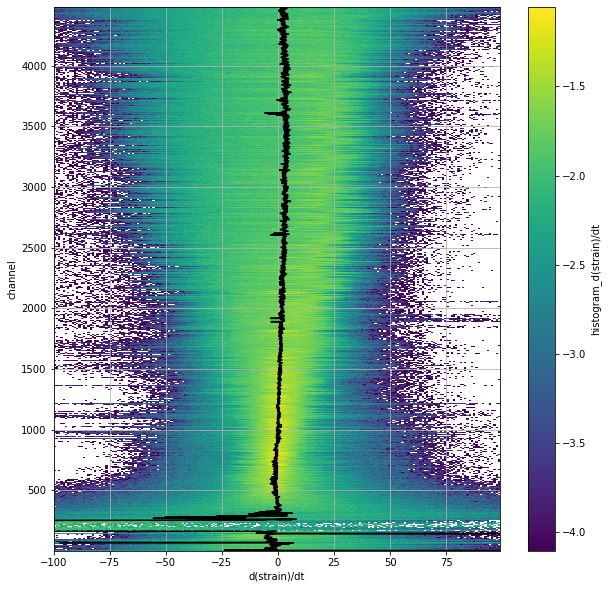

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_t).plot()
dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


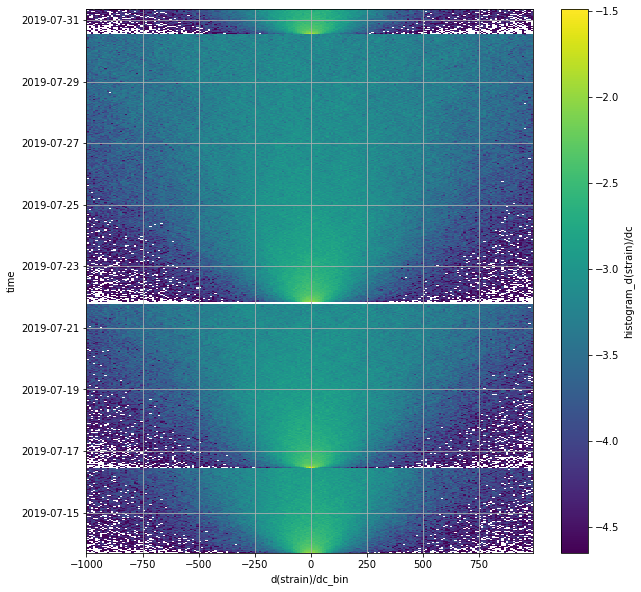

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_c).plot()
#dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

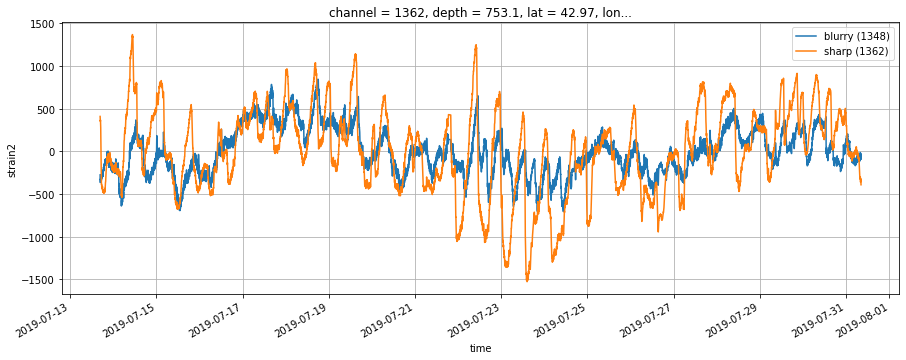

Compare spectra

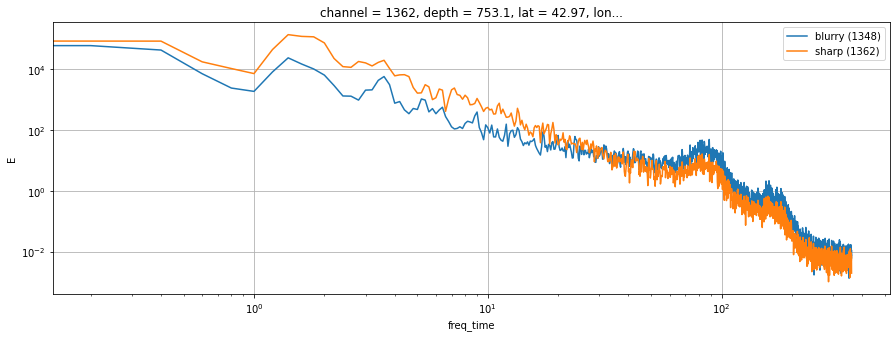